In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import matplotlib.dates as mdates
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional
from keras.optimizers import SGD
from sklearn.metrics import mean_squared_error

c:\Python310\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
dataset = pd.read_excel('grocery_price.xlsx', index_col=None)
dataset.head()

,Date,10/03/2021,11/03/2021,12/03/2021,13/03/2021,14/03/2021,15/03/2021,16/03/2021,17/03/2021,18/03/2021,...,18/12/2023,19/12/2023,20/12/2023,21/12/2023,22/12/2023,23/12/2023,24/12/2023,25/12/2023,26/12/2023,27/12/2023
0,Beras,11.5,11.5,11.5,11.5,11.5,11.5,11.61,12.10,11.72,...,14.37,14.37,14.35,14.27,14.33,14.41,14.34,14.33,14.37,14.42
1,Gula Pasir,14.0,14.0,14.0,14.0,14.0,14.0,13.56,13.41,13.60,...,17.77,17.71,17.76,17.80,17.77,17.73,17.72,17.74,17.73,17.73
2,Minyak Goreng,14.5,14.0,14.0,14.0,14.0,14.0,14.26,13.96,14.13,...,17.50,17.40,17.48,17.42,17.14,17.65,17.27,17.47,17.21,17.45


In [3]:
# transform data to from row to column
dataset = dataset.T
dataset.columns = dataset.iloc[0]
dataset = dataset.drop(dataset.index[0])

dataset.head()

Date,Beras,Gula Pasir,Minyak Goreng
10/03/2021,11.5,14.0,14.5
11/03/2021,11.5,14.0,14.0
12/03/2021,11.5,14.0,14.0
13/03/2021,11.5,14.0,14.0
14/03/2021,11.5,14.0,14.0


In [4]:
# add new column to dataset, average of all column 
dataset['Average'] = round(dataset.mean(axis=1),2)

# remove column 2
dataset = dataset.drop(dataset.columns[0:3], axis=1)

dataset.head()

Date,Average
10/03/2021,13.33
11/03/2021,13.17
12/03/2021,13.17
13/03/2021,13.17
14/03/2021,13.17


In [5]:
# split data into training, validation, and test
# 80, 20, 28 hari
train_data = dataset.iloc[0:791] 
validation_data = dataset.iloc[791:995] 
test_data = dataset.iloc[995:1023] 

# change to numpy array
train_data = train_data.values
validation_data = validation_data.values

train_data

array([[13.33],
       [13.17],
       [13.17],
       [13.17],
       [13.17],
       [13.17],
       [13.14],
       [13.16],
       [13.15],
       [13.2 ],
       [13.2 ],
       [13.25],
       [13.17],
       [13.27],
       [13.2 ],
       [13.16],
       [13.24],
       [13.18],
       [13.12],
       [13.22],
       [13.21],
       [13.16],
       [13.24],
       [13.15],
       [13.1 ],
       [13.23],
       [13.19],
       [13.18],
       [13.26],
       [13.18],
       [13.2 ],
       [13.21],
       [13.08],
       [13.26],
       [13.18],
       [13.25],
       [13.24],
       [13.26],
       [13.2 ],
       [13.3 ],
       [13.26],
       [13.18],
       [13.12],
       [13.24],
       [13.35],
       [13.33],
       [13.25],
       [13.21],
       [13.21],
       [13.29],
       [13.23],
       [13.18],
       [13.27],
       [13.24],
       [13.2 ],
       [13.26],
       [13.25],
       [13.21],
       [13.31],
       [13.19],
       [13.34],
       [13.26],
       [

In [6]:
# normalize using minmaxscaler


sc = MinMaxScaler(feature_range=(0,1))
train_data_scaled = sc.fit_transform(train_data)
validation_data_scaled = sc.fit_transform(validation_data)
train_data_scaled

array([[0.07331378],
       [0.02639296],
       [0.02639296],
       [0.02639296],
       [0.02639296],
       [0.02639296],
       [0.01759531],
       [0.02346041],
       [0.02052786],
       [0.03519062],
       [0.03519062],
       [0.04985337],
       [0.02639296],
       [0.05571848],
       [0.03519062],
       [0.02346041],
       [0.04692082],
       [0.02932551],
       [0.01173021],
       [0.04105572],
       [0.03812317],
       [0.02346041],
       [0.04692082],
       [0.02052786],
       [0.0058651 ],
       [0.04398827],
       [0.03225806],
       [0.02932551],
       [0.05278592],
       [0.02932551],
       [0.03519062],
       [0.03812317],
       [0.        ],
       [0.05278592],
       [0.02932551],
       [0.04985337],
       [0.04692082],
       [0.05278592],
       [0.03519062],
       [0.06451613],
       [0.05278592],
       [0.02932551],
       [0.01173021],
       [0.04692082],
       [0.07917889],
       [0.07331378],
       [0.04985337],
       [0.038

In [7]:
# create input sequences

def create_sequences(data, seq_length=60):
    x=[]
    y=[]
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i,0])
        y.append(data[i,0])
    return np.array(x), np.array(y)

x_train, y_train = create_sequences(train_data_scaled)
x_val, y_val = create_sequences(validation_data_scaled)

# reshape input for model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

In [8]:
# Building the LSTM Model
# model = keras.Sequential()
# model.add(keras.layers.LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# model.add(keras.layers.Dropout(0.3))
# model.add(keras.layers.LSTM(units=80, return_sequences=True))
# model.add(keras.layers.Dropout(0.1))
# model.add(keras.layers.LSTM(units=50, return_sequences=True))
# model.add(keras.layers.Dropout(0.2))
# model.add(keras.layers.LSTM(units=30))
# model.add(keras.layers.Dropout(0.3))
# model.add(keras.layers.Dense(units=1))

In [9]:
# The GRU architecture
model = keras.Sequential()
# First GRU layer with Dropout regularisation
model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
model.add(Dropout(0.2))
# Second GRU layer
model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
model.add(Dropout(0.2))
# Third GRU layer
model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
model.add(Dropout(0.2))
# Fourth GRU layer
model.add(GRU(units=50, activation='tanh'))
model.add(Dropout(0.2))
# The output layer
model.add(Dense(units=1))



In [10]:
#  Compiling the LSTM Model
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the Model and store history
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val))

model.save('GRU.h5')

Epoch 1/100
23/23 [==============================] - 6s 75ms/step - loss: 0.0903 - val_loss: 0.0119
Epoch 2/100
23/23 [==============================] - 1s 44ms/step - loss: 0.0123 - val_loss: 0.0029
Epoch 3/100
23/23 [==============================] - 1s 44ms/step - loss: 0.0086 - val_loss: 0.0051
Epoch 4/100
23/23 [==============================] - 1s 47ms/step - loss: 0.0072 - val_loss: 0.0051
Epoch 5/100
23/23 [==============================] - 1s 46ms/step - loss: 0.0058 - val_loss: 0.0039
Epoch 6/100
23/23 [==============================] - 1s 47ms/step - loss: 0.0057 - val_loss: 0.0034
Epoch 7/100
23/23 [==============================] - 1s 45ms/step - loss: 0.0056 - val_loss: 0.0030
Epoch 8/100
23/23 [==============================] - 1s 47ms/step - loss: 0.0060 - val_loss: 0.0032
Epoch 9/100
23/23 [==============================] - 1s 48ms/step - loss: 0.0045 - val_loss: 0.0034
Epoch 10/100
23/23 [==============================] - 1s 45ms/step - loss: 0.0054 - val_loss: 0.0058

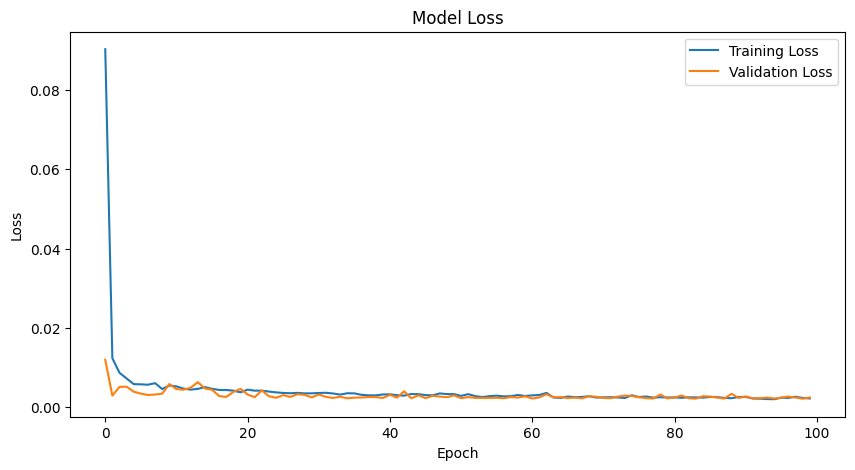

In [11]:
# Plot loss and accuracy during training
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:

real_price = test_data.iloc[:,0].values.reshape(-1,1)
real_price

array([[16.35],
       [16.49],
       [16.47],
       [16.34],
       [16.59],
       [16.49],
       [16.48],
       [16.46],
       [16.55],
       [16.3 ],
       [16.47],
       [16.53],
       [16.53],
       [16.57],
       [16.56],
       [16.54],
       [16.52],
       [16.57],
       [16.55],
       [16.49],
       [16.53],
       [16.5 ],
       [16.41],
       [16.6 ],
       [16.44],
       [16.51],
       [16.44],
       [16.53]])

In [13]:
dataset_total = pd.concat((dataset['Average'], test_data['Average']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test_data) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
x_test = []
for i in range(60, len(inputs)):
    x_test.append(inputs[i-60:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [14]:
predicted_price = model.predict(x_test)
predicted_price = sc.inverse_transform(predicted_price)

# round each value in predicted_price
predicted_price = np.round(predicted_price,2)

1/1 [==============================] - 1s 707ms/step


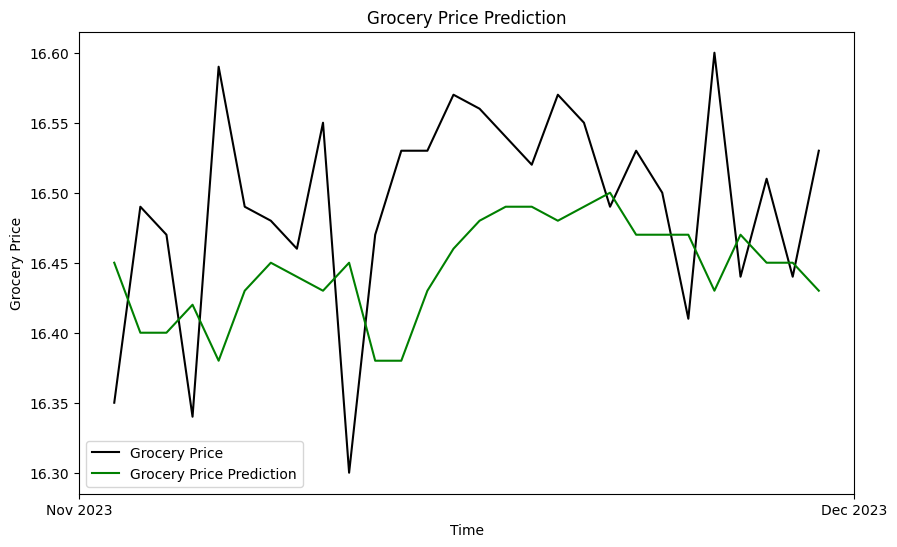

In [15]:
# Prepare dates for the predicted stock prices
date_range = pd.date_range(start='2023-11-30', periods=len(predicted_price), freq='D') 

# visualizing the results
plt.figure(figsize=(10, 6))
plt.plot(date_range, real_price, color='black', label='Grocery Price')
plt.plot(date_range, predicted_price, color='green', label='Grocery Price Prediction')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show tick marks for every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format x-axis labels as 'Jan 2023', 'Feb 2023', etc.
plt.title('Grocery Price Prediction')
plt.xlabel('Time')
plt.ylabel('Grocery Price')
plt.legend()
plt.show()